In this notebook, I induce Rabi oscillation without DRAG correction

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [26]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [27]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

[<IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>]


In [28]:
rough_qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
rough_qubit_12_freq = rough_qubit_01_freq + qubit_anharmonicty

In [29]:
rough_qubit_12_freq, rough_qubit_01_freq

(4677859501.519471, 4984975303.503737)

In [30]:
with pulse.build(backend=backend) as delay_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(10000, drive_chan)
    
delay_gate = Gate('Delay 5us', weight, [])

## Rabi circuits

In [31]:
amps = np.linspace(-1, 1, 100)

rabi_circs = []

rabi12_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_qubit_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=80, amp=amp, sigma=20, beta=0), drive_chan)

    rabi12_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi12_circ.append(delay_gate, [qubit])
    rabi12_circ.x(qubit)
    rabi12_circ.append(rabi12_gate, [qubit])
    rabi12_circ.measure(qubit, cbit)
    rabi12_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)
    rabi12_circ.add_calibration(delay_gate, [qubit], delay_sched)
                   
    rabi_circs.append(rabi12_circ)
    
rabi_circs = qiskit.transpile(rabi_circs, backend=backend)

In [25]:
rough_rabi_exp = backend.run(rabi_circs, meas_level=1, meas_return='avg', shots=2048)

In [38]:
rough_rabi_exp = provider.backend.retrieve_job('cnx6k6wsdyyg0080k0h0')

In [39]:
rough_rabi_data = DataAnalysis(experiment=rough_rabi_exp, average=True, shots=2048, qubit=0)
rough_rabi_data.retrieve_data(average=True)

In [41]:
import pickle

with open('./calibrator/rabi/data/14dec/rabi80_2.pkl', 'wb') as f:
    pickle.dump(rabi80_2, f)

In [45]:
rabi96_1 = np.load('./calibrator/rabi/data/14dec/rabi96.pkl', allow_pickle=True)
rabi96_2 = np.load('./calibrator/rabi/data/14dec/rabi96_2.pkl', allow_pickle=True)

In [48]:
rabi96 = [(rabi96_1[i]+rabi96_2[i])*0.5 for i in range(len(amps))]

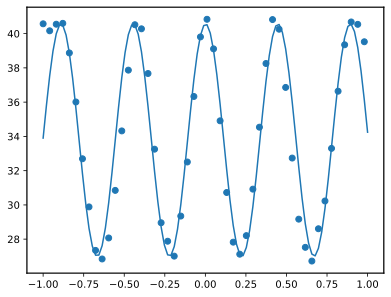

In [55]:
plt.scatter(amps[::2], rabi96[::2])

rabi12_params, rabi12_fit = fit_function(amps, rabi96, 
                    lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                    [40, 0, 0.4, 0])

plt.plot(amps, rabi12_fit)

In [51]:
rabi12_params[2]/2

0.22289722723304814